In [12]:
from datagen import create_file_pairs
import uproot
import numpy as np
import matplotlib.pyplot as plt
from plotting import plot_histogram, plot_log_residual_contour
import awkward as ak

In [17]:
branch = "AnalysisElectronsAuxDyn"
varnames = ["pt"]  # or ["pt", "eta", "phi"], etc.

batch_size = 1000
files = create_file_pairs("sim")
files

[('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6490/mc20_13TeV.410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.deriv.DAOD_PHYSLITE.e6337_s3681_r13167_r13146_p6490/DAOD_PHYSLITE.41651753._000007.pool.root.1',
  '/eos/user/y/yolanney/compressed_files/sim/DAOD_PHYSLITE.41651753._000007.pool.root_dl10_compressed.root',
  'sim'),
 ('/cvmfs/atlas-nightlies.cern.ch/repo/data/data-art/ASG/DAOD_PHYSLITE/p6491/mc23_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8514_e8528_s4162_s4114_r15540_r15516_p6491/DAOD_PHYSLITE.41633384._000941.pool.root.1',
  '/eos/user/y/yolanney/compressed_files/sim/DAOD_PHYSLITE.41633384._000941.pool.root_dl10_compressed.root',
  'sim')]

In [18]:
files[0]  # This will be a tuple of (clean_file, noisy_file)
file = files[0][0]

In [19]:
tree = uproot.open({file: "CollectionTree"})
all_keys = tree.keys()
# Find keys containing 'electron' (case insensitive)
electron_keys = [key for key in all_keys if 'electron' in key.lower()]

# Print results
print(f"Found {len(electron_keys)} electron-related branches:")
for key in electron_keys:
    print(f"  - {key}")


Found 113 electron-related branches:
  - AnalysisElectronsAux.
  - AnalysisSiHitElectronsAux.
  - TruthElectronsAux.
  - AnalysisElectrons
  - AnalysisSiHitElectrons
  - TruthElectrons
  - AnalysisElectronsAuxDyn.trackParticleLinks
  - AnalysisElectronsAuxDyn.ambiguityLink
  - AnalysisElectronsAuxDyn.ambiguityLink/AnalysisElectronsAuxDyn.ambiguityLink.m_persKey
  - AnalysisElectronsAuxDyn.ambiguityLink/AnalysisElectronsAuxDyn.ambiguityLink.m_persIndex
  - AnalysisElectronsAuxDyn.pt
  - AnalysisElectronsAuxDyn.eta
  - AnalysisElectronsAuxDyn.phi
  - AnalysisElectronsAuxDyn.m
  - AnalysisElectronsAuxDyn.charge
  - AnalysisElectronsAuxDyn.topoetcone20
  - AnalysisElectronsAuxDyn.f1
  - AnalysisElectronsAuxDyn.truthType
  - AnalysisElectronsAuxDyn.truthOrigin
  - AnalysisElectronsAuxDyn.truthParticleLink
  - AnalysisElectronsAuxDyn.truthParticleLink/AnalysisElectronsAuxDyn.truthParticleLink.m_persKey
  - AnalysisElectronsAuxDyn.truthParticleLink/AnalysisElectronsAuxDyn.truthParticleLink.m_

In [20]:
branch = tree["AnalysisElectronsAuxDyn.pt"]

# Quick inspection methods
print(f"Branch name: {branch.name}")
# print(f"Type: {branch.type}")  # Shows the data type
print(f"Number of entries: {branch.num_entries}")  # Total entries
print(f"Interpretation: {branch.interpretation}")  # How data is structured
analysis = ak.flatten(branch.array()).to_numpy()


branch = tree["TruthElectronsAuxDyn.ptcone30"]

# Quick inspection methods
print(f"Branch name: {branch.name}")
# print(f"Type: {branch.type}")  # Shows the data type
print(f"Number of entries: {branch.num_entries}")  # Total entries
print(f"Interpretation: {branch.interpretation}")  # How data is structured
truth = ak.flatten(branch.array()).to_numpy()

branch = tree["AnalysisElectronsAuxDyn.truthParticleLink"]
print(f"Branch name: {branch.name}")
# print(f"Type: {branch.type}")  # Shows the data type
print(f"Number of entries: {branch.num_entries}")  # Total entries
print(f"Interpretation: {branch.interpretation}")  # How data is structured


Branch name: AnalysisElectronsAuxDyn.pt
Number of entries: 40000
Interpretation: AsJagged(AsDtype('>f4'), header_bytes=10)
Branch name: TruthElectronsAuxDyn.ptcone30
Number of entries: 40000
Interpretation: AsJagged(AsDtype('>f4'), header_bytes=10)
Branch name: AnalysisElectronsAuxDyn.truthParticleLink
Number of entries: 40000
Interpretation: AsGroup(<TBranchElement 'AnalysisElectronsAuxDyn.truthParticleLink' (2 subbranches) at 0x7fd00a6c5690>, {'AnalysisElectronsAuxDyn.truthParticleLink.m_persKey': AsJagged(AsDtype('>u4')), 'AnalysisElectronsAuxDyn.truthParticleLink.m_persIndex': AsJagged(AsDtype('>u4'))})


In [29]:
# Load analysis electron branches
analysis_pt = tree["AnalysisElectronsAuxDyn.pt"].array()
truth_idx   = tree["AnalysisElectronsAuxDyn.truthParticleLink.m_persIndex"].array()

# Load truth particle 4-momenta
truth_px = tree["TruthElectronsAuxDyn.px"].array()
truth_py = tree["TruthElectronsAuxDyn.py"].array()
truth_pz = tree["TruthElectronsAuxDyn.pz"].array()
truth_e  = tree["TruthElectronsAuxDyn.e"].array()

# Load flattened truth electron arrays (outside of event nesting)
truth_px_flat = ak.flatten(truth_px)
truth_py_flat = ak.flatten(truth_py)
truth_pz_flat = ak.flatten(truth_pz)
truth_e_flat  = ak.flatten(truth_e)

# Load the link indices (per event, per reco electron)
truth_idx = tree["AnalysisElectronsAuxDyn.truthParticleLink.m_persIndex"].array()

# Now index into the flat truth arrays
matched_truth_px = ak.Array([
    [truth_px_flat[idx] if idx >= 0 and idx < len(truth_px_flat) else None for idx in event]
    for event in truth_idx
])

matched_truth_py = ak.Array([
    [truth_py_flat[idx] if idx >= 0 and idx < len(truth_py_flat) else None for idx in event]
    for event in truth_idx
])

matched_truth_pz = ak.Array([
    [truth_pz[idx] if idx >= 0 and idx < len(truth_pz) else None for idx in event]
    for event in truth_idx
])

matched_truth_e = ak.Array([
    [truth_e_flat[idx] if idx >= 0 and idx < len(truth_e_flat) else None for idx in event]
    for event in truth_idx
])

# Optional: you can now compute ΔR, ΔpT, etc.

import vector

# Make 4-vectors
truth_vecs = vector.arr({
    "px": matched_truth_px,
    "py": matched_truth_py,
    "pz": matched_truth_pz,
    "E":  matched_truth_e,
})

analysis_vecs = vector.arr({
    "pt": analysis_pt,
    "eta": tree["AnalysisElectronsAuxDyn.eta"].array(),
    "phi": tree["AnalysisElectronsAuxDyn.phi"].array(),
    "mass": tree["AnalysisElectronsAuxDyn.m"].array()
})

# Compute ΔR
delta_R = analysis_vecs.deltaR(truth_vecs)


In [35]:
for i in range(20):
    print("Event", i)
    print("  Reco electron count:", len(truth_idx[i]))
    print("  Truth electrons in event:", len(truth_px[i]))
    print("  Truth indices:", truth_idx[i])


Event 0
  Reco electron count: 1
  Truth electrons in event: 3
  Truth indices: [384]
Event 1
  Reco electron count: 0
  Truth electrons in event: 1
  Truth indices: []
Event 2
  Reco electron count: 0
  Truth electrons in event: 6
  Truth indices: []
Event 3
  Reco electron count: 0
  Truth electrons in event: 4
  Truth indices: []
Event 4
  Reco electron count: 1
  Truth electrons in event: 7
  Truth indices: [756]
Event 5
  Reco electron count: 1
  Truth electrons in event: 5
  Truth indices: [709]
Event 6
  Reco electron count: 3
  Truth electrons in event: 5
  Truth indices: [790, 2118, 2080]
Event 7
  Reco electron count: 0
  Truth electrons in event: 0
  Truth indices: []
Event 8
  Reco electron count: 0
  Truth electrons in event: 5
  Truth indices: []
Event 9
  Reco electron count: 1
  Truth electrons in event: 3
  Truth indices: [552]
Event 10
  Reco electron count: 0
  Truth electrons in event: 1
  Truth indices: []
Event 11
  Reco electron count: 1
  Truth electrons in even

Number of events: 40000
ΔR values for first event: [[2.88, 2.87, 3.13, 3.47]]
ΔR for first reco electron: [2.88, 2.87, 3.13, 3.47]
Flattened ΔR length: 94597
min ΔR: 0.01737293357943741
max ΔR: 15.720378134168689


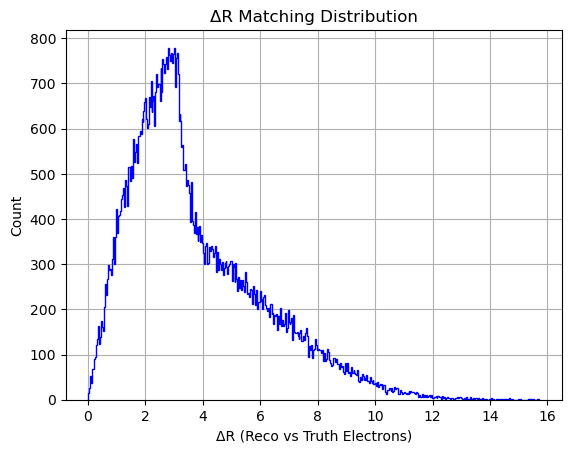

In [43]:
# How many events?
print(f"Number of events: {len(delta_R)}")

# For the first event
print("ΔR values for first event:", delta_R[0])

# For first reco electron in first event
print("ΔR for first reco electron:", delta_R[0][0])

import matplotlib.pyplot as plt

# Flatten to remove event nesting
delta_R_flat = ak.flatten(delta_R)
delta_R_flat = delta_R_flat[~ak.is_none(delta_R_flat)]
delta_R_flat = ak.flatten(delta_R_flat)  # 👈 important: flatten again
delta_R_np = ak.to_numpy(delta_R_flat)
print("Flattened ΔR length:", len(delta_R_np))
print("min ΔR:", np.min(delta_R_np))
print("max ΔR:", np.max(delta_R_np))

# Drop None values (if any)
delta_R_flat = delta_R_flat[~ak.is_none(delta_R_flat)]  # ✅ filters out None

# Convert to NumPy for plotting
delta_R_np = ak.to_numpy(delta_R_flat)

# Plot histogram
plt.hist(delta_R_np, bins=500, histtype='step', color='blue')
plt.xlabel("ΔR (Reco vs Truth Electrons)")
plt.ylabel("Count")
plt.title("ΔR Matching Distribution")
plt.grid(True)
plt.show()


In [32]:
len(truth_px)

40000

In [ ]:

plot_histogram((analysis, truth), varnames=["analysis", "truth"], log=True, n_bins=100)

Reco pt: 26115 entries
Truth pt: 156145 entries
Reco eta: 26115 entries
Truth eta: 156145 entries
Reco phi: 26115 entries
Truth phi: 156145 entries


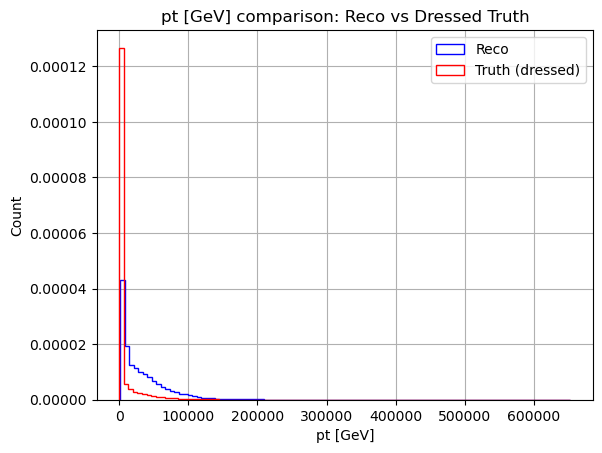

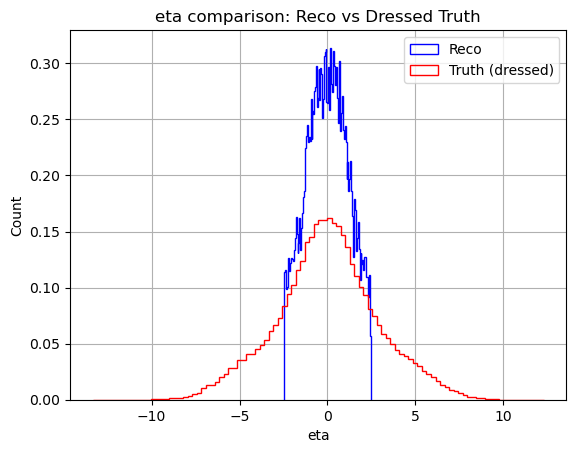

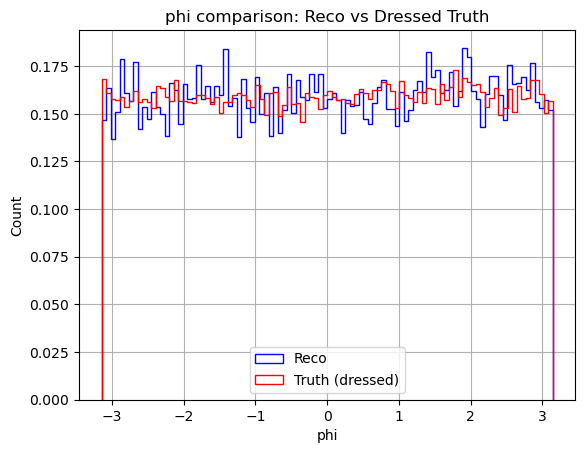

In [52]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np

# Get 1D flattened arrays for reco and truth quantities
pt_reco = ak.to_numpy(ak.flatten(tree["AnalysisElectronsAuxDyn.pt"].array()))
eta_reco = ak.to_numpy(ak.flatten(tree["AnalysisElectronsAuxDyn.eta"].array()))
phi_reco = ak.to_numpy(ak.flatten(tree["AnalysisElectronsAuxDyn.phi"].array()))

pt_truth = ak.to_numpy(ak.flatten(tree["TruthElectronsAuxDyn.pt_dressed"].array()))
eta_truth = ak.to_numpy(ak.flatten(tree["TruthElectronsAuxDyn.eta_dressed"].array()))
phi_truth = ak.to_numpy(ak.flatten(tree["TruthElectronsAuxDyn.phi_dressed"].array()))

print(f"Reco pt: {len(pt_reco)} entries")
print(f"Truth pt: {len(pt_truth)} entries")
print(f"Reco eta: {len(eta_reco)} entries")
print(f"Truth eta: {len(eta_truth)} entries")
print(f"Reco phi: {len(phi_reco)} entries")
print(f"Truth phi: {len(phi_truth)} entries")

# Plotting function
def compare_hist(reco, truth, varname, bins=50):
    plt.figure()
    plt.hist(reco, bins=bins, histtype='step', label='Reco', color='blue', density=True)
    plt.hist(truth, bins=bins, histtype='step', label='Truth (dressed)', color='red', density=True)
    plt.xlabel(varname)
    plt.ylabel("Count")
    plt.title(f"{varname} comparison: Reco vs Dressed Truth")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot each variable
compare_hist(pt_reco, pt_truth, "pt [GeV]", bins=100)
compare_hist(eta_reco, eta_truth, "eta", bins=100)
compare_hist(phi_reco, phi_truth, "phi", bins=100)
